In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="H4mhRq8LuWE4QH1adiz7")
project = rf.workspace("ishhiyy").project("delhi_buildings")
version = project.version(1)
dataset = version.download("png-mask-semantic")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to delhi_buildings-1 in png-mask-semantic:: 100%|██████████| 144/144 [00:00<00:00, 1713.17it/s]


In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install pydantic==1.10.8
!pip install torch-snippets --upgrade
from pydantic import BaseModel as ModelMetaclass


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.7.1
    Uninstalling pydantic-2.7.1:
      Successfully uninstalled pydantic-2.7.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 65.5 MB/s eta 0:00:0

In [ ]:
!pip install torch-snippets==0.495
from torch_snippets import *

The dataset consists of $151$ aerial images of the Boston area. It covers mostly urban and suburban areas and buildings of all sizes. Each of the images has $1500 \times 1500$ pixels for an area of $2.25$ square kilometers. In total the dataset covers $340$ square kilometers area.

An accompanying **metadata.csv** is provided with each image ID, the split it belongs to, image urls and path to it.

In [ ]:
IMG_ROOT = 'https://universe.roboflow.com/ishhiyy/delhi_buildings'
df = pd.read_csv('/kaggle/input/massachusetts-buildings-dataset/metadata.csv')

train_df = df.loc[df['split'] == 'train']
tst_df = df.loc[df['split'] == 'test']
print("Training dataset size:", len(train_df))
print("Test dataset size:", len(tst_df))

Training dataset size: 137
Test dataset size: 10


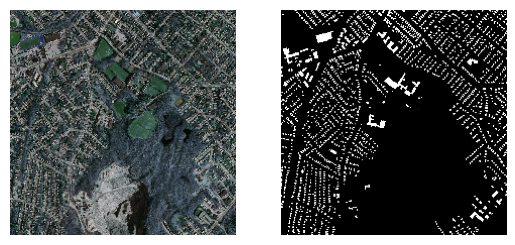

In [ ]:
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

tfms = transforms.Compose([
#     transforms.RandomHorizontalFlip(0.3),
#     transforms.RandomRotation(40),
#     transforms.RandomVerticalFlip(0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # imagenet
                         [0.229, 0.224, 0.225])
])

class BuildingDataset(Dataset):
    def __init__(self, df, root=IMG_ROOT):
        self.df = df
        self.root = root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        w, h = 224, 224
        img_path = self.root+self.df.iloc[idx]['png_image_path']
        mask_path = self.root+self.df.iloc[idx]['png_label_path']
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        img = cv2.resize(img, (224, 224))
        mask = cv2.resize(mask, (224, 224))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        return img, mask

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images = torch.cat([tfms(img.copy()/255.)[None] for img in images]).float().to(device)
        masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return images, masks

tr_ds = BuildingDataset(train_df)
tst_ds = BuildingDataset(tst_df)

tr_dl = DataLoader(tr_ds, batch_size=4, drop_last=True, shuffle=True,
                  collate_fn=tr_ds.collate_fn)
tst_dl = DataLoader(tr_ds, batch_size=1, drop_last=True, shuffle=True,
                  collate_fn=tst_ds.collate_fn)

img, mask = tr_ds[10]
fig, ax = plt.subplots(1, 2)
show(img, ax=ax[0])
show(mask, ax=ax[1])

**Model**


In [ ]:
import torch.nn as nn
from torchvision.models import vgg16_bn

def conv(in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3,
                stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
     nn.ConvTranspose2d(in_channels, out_channels,
                         kernel_size=2, stride=2),
     nn.ReLU(inplace=True)
  )

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()
        self.backbone = vgg16_bn(pretrained=True).to(device).features
        self.down1 = nn.Sequential(*self.backbone[:6]) # 64
        self.down2 = nn.Sequential(*self.backbone[6:13]) # 128
        self.down3 = nn.Sequential(*self.backbone[13:20]) # 256
        self.down4 = nn.Sequential(*self.backbone[20:27]) # 512
        self.down5 = nn.Sequential(*self.backbone[27:34]) # 512

        self.bottleneck = nn.Sequential(*self.backbone[34:]) # 512
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv5 = up_conv(1024, 512)
        self.merge_conv5 = conv(512+512, 512)
        self.up_conv4 = up_conv(512, 256)
        self.merge_conv4 = conv(512 + 256, 256)
        self.up_conv3 = up_conv(256, 128)
        self.merge_conv3 = conv(256+128, 128)
        self.up_conv2 = up_conv(128, 64)
        self.merge_conv2 = conv(128+64, 64)
        self.up_conv1 = up_conv(64, 32)
        self.merge_conv1 = conv(32+64, 32)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # encoder
        x_1 = self.down1(x)
        x_2 = self.down2(x_1)
        x_3 = self.down3(x_2)
        x_4 = self.down4(x_3)
        x_5 = self.down5(x_4)
        # bottleneck
        x = self.bottleneck(x_5)
        x = self.conv_bottleneck(x)
        # decoder
        x = self.up_conv5(x)
        x = self.merge_conv5(torch.cat([x, x_5], dim=1))
        x = self.up_conv4(x)
        x = self.merge_conv4(torch.cat([x, x_4], dim=1))
        x = self.up_conv3(x)
        x = self.merge_conv3(torch.cat([x, x_3], dim=1))
        x = self.up_conv2(x)
        x = self.merge_conv2(torch.cat([x, x_2], dim=1))
        x = self.up_conv1(x)
        x = self.merge_conv1(torch.cat([x, x_1], dim=1))

        x = self.final_conv(x)
        return x

model = UNet().to(device)
model(torch.zeros((1, 3, 224, 224)).to(device))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:07<00:00, 73.0MB/s]


tensor([[[[ 1.0187e+00, -1.1596e+00, -1.4277e+00,  ..., -1.6832e+00,
           -5.3804e-01, -1.8766e+00],
          [-5.0099e-01, -5.1409e-01, -1.4687e+00,  ..., -9.9377e-01,
            3.5188e-01, -6.7020e-01],
          [ 6.2820e-01,  1.4556e+00, -4.5128e-01,  ..., -5.9783e-01,
           -1.4643e+00, -2.1193e+00],
          ...,
          [ 8.6494e-01,  1.6487e+00,  3.5769e-01,  ..., -4.5583e-01,
           -6.2651e-01, -9.1722e-01],
          [ 2.8706e+00,  3.6445e+00,  1.4026e+00,  ...,  9.0787e-01,
           -1.4056e+00,  9.6237e-02],
          [-3.7761e-01,  6.2775e-01, -1.5752e+00,  ..., -2.1208e+00,
           -4.4417e+00, -3.0058e+00]],

         [[ 8.6165e-01,  2.0428e+00,  2.5401e+00,  ...,  2.6120e+00,
            7.6322e-01,  2.7818e+00],
          [-2.2931e+00, -1.0258e+00, -3.0373e+00,  ..., -3.1440e+00,
           -2.8037e+00, -2.7648e+00],
          [-2.0306e+00, -8.1322e-02, -6.0622e-01,  ...,  3.8198e-01,
           -5.5955e-01,  6.4912e-01],
          ...,
     

**Training**

In [ ]:
def loss_fn(preds, targets):
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return loss, acc

def train_batch(model, batch, optim, loss_fn):
    model.train()
    imgs, masks = batch
    pred_masks = model(imgs)
    optim.zero_grad()
    loss, acc = loss_fn(pred_masks, masks)
    loss.backward()
    optim.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, batch, loss_fn):
    model.eval()
    imgs, masks = batch
    pred_masks = model(imgs)
    loss, acc = loss_fn(pred_masks, masks)
    return loss.item(), acc.item()

model = UNet(out_channels=300).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = loss_fn
n_epochs = 10
log = Report(n_epochs)
for e in range(n_epochs):
    N = len(tr_dl)
    for i, batch in enumerate(tr_dl):
        loss, acc = train_batch(model, batch, optim, loss_fn)
        log.record(e+(i+1)/N, trn_loss=loss, trn_acc=acc, end='\r')
    N = len(tst_dl)
    for i, batch in enumerate(tst_dl):
        loss, acc = validate_batch(model, batch, loss_fn)
        log.record(e+(i+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(e+1)
torch.save(model.state_dict(), "best_model.pt")

EPOCH: 1.000	trn_loss: 5.172	trn_acc: 0.365	val_loss: 12.423	val_acc: 0.408	(653.84s - 5884.60s remaining)
EPOCH: 2.000	trn_loss: 4.208	trn_acc: 0.617	val_loss: 4.000	val_acc: 0.638	(1306.07s - 5224.29s remaining)
EPOCH: 3.000	trn_loss: 3.204	trn_acc: 0.617	val_loss: 2.502	val_acc: 0.610	(1962.94s - 4580.20s remaining)
EPOCH: 4.000	trn_loss: 2.186	trn_acc: 0.629	val_loss: 1.831	val_acc: 0.624	(2616.99s - 3925.48s remaining)
EPOCH: 5.000	trn_loss: 1.346	trn_acc: 0.685	val_loss: 0.999	val_acc: 0.862	(3273.76s - 3273.76s remaining)
EPOCH: 6.000	trn_loss: 0.869	trn_acc: 0.862	val_loss: 0.742	val_acc: 0.872	(3930.48s - 2620.32s remaining)
EPOCH: 7.000	trn_loss: 0.694	trn_acc: 0.871	val_loss: 0.695	val_acc: 0.873	(4576.72s - 1961.45s remaining)
EPOCH: 8.000	trn_loss: 0.653	trn_acc: 0.872	val_loss: 0.609	val_acc: 0.877	(5224.71s - 1306.18s remaining)
EPOCH: 9.000	trn_loss: 0.619	trn_acc: 0.875	val_loss: 0.604	val_acc: 0.876	(5877.59s - 653.07s remaining)
EPOCH: 10.000	trn_loss: 0.607	trn_acc:

100%|██████████| 111/111 [00:00<00:00, 2510.38it/s]


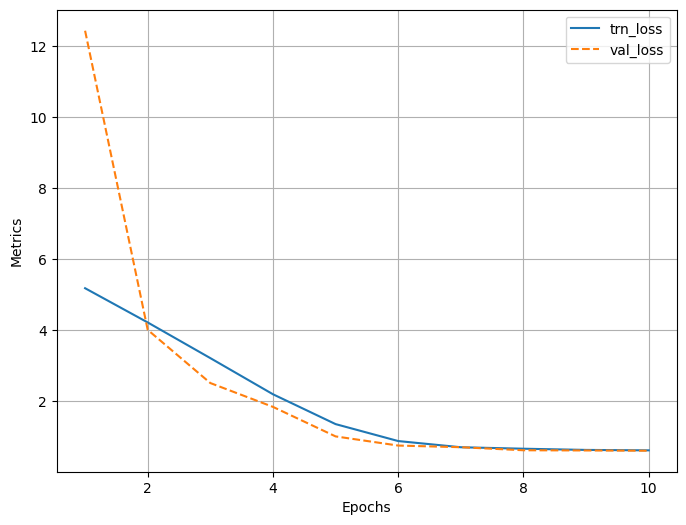

In [ ]:
log.plot_epochs(['trn_loss', 'val_loss'])

<a id="1"></a>
# <p style="padding:10px;background-color:#a7fabd;margin:0;color:black;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 100px 50px;overflow:hidden;font-weight:500">Testing</p>

In [ ]:
newdf = tst_dl

In [ ]:
import os

print(os.listdir('/kaggle/working/'))
import torch

try:
    model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))
except FileNotFoundError as e:
    print(f"File not found: {e}")


[]
File not found: [Errno 2] No such file or directory: '/kaggle/working/best_model.pt'


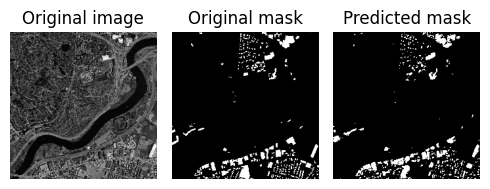

In [ ]:
im, mask = next(iter(tst_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])

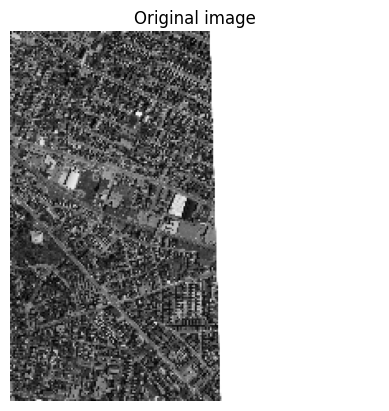

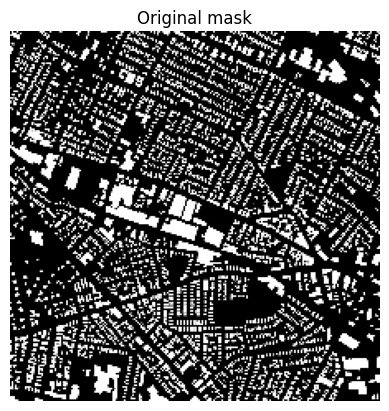

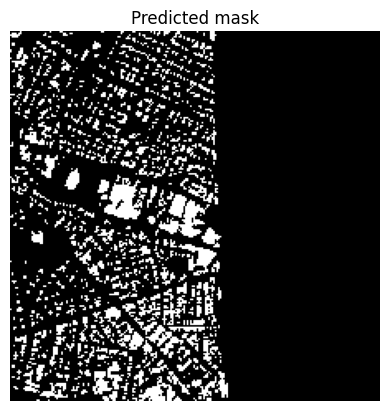

In [ ]:
# Get a batch of data from the dataloader
im, mask = next(iter(tst_dl))

# Forward pass through the model
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)

# Detach and move tensors to CPU for visualization
im = im[0].permute(1, 2, 0).detach().cpu()
mask = mask.permute(1, 2, 0).detach().cpu()
_mask = _mask.permute(1, 2, 0).detach().cpu()

# Plot original image
plt.figure()
plt.imshow(im[:, :, 0], cmap='gray')
plt.axis('off')
plt.title('Original image')
plt.savefig('original_image.png')
# Plot original mask
plt.figure()
plt.imshow(mask[:, :, 0], cmap='gray')
plt.axis('off')
plt.title('Original mask')
plt.savefig('original_mask.png')
# Plot predicted mask
plt.figure()
plt.imshow(_mask[:, :, 0], cmap='gray')
plt.axis('off')
plt.title('Predicted mask')
plt.savefig('predicted_mask.png')
# Display the plots
plt.show()
